In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import scipy
import _pickle as pickle
import seaborn as sns
import tensorflow as tf
from keras.layers import Permute, Dense, multiply, Input, Embedding, Bidirectional, LSTM
from keras.models import Model


In [34]:
df = pd.read_csv("data/covid19_articles_20201231_reduced.csv")

WE_BIGRAM_PHRASER_FILEPATH = "we_bigram_phraser.pkl"
bigram_phraser = pickle.load(open(WE_BIGRAM_PHRASER_FILEPATH, "rb"))

WORD_EMBEDDINGS_FILEPATH = "processed_data/local_word_embeddings.model"
nlp = gensim.models.Word2Vec.load(WORD_EMBEDDINGS_FILEPATH)


In [35]:
## Tokenizer taken from TensorFLow
## https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer()


In [36]:
MAX_LENGTH = 15
_ = []
for sen in df["content"]:
    w = sen.split()
    _.append(w)
## get bigrams
_ = list(bigram_phraser[_])
## fit tokenizer
tokenizer.fit_on_texts(_)
## create sequences
seqences = tokenizer.texts_to_sequences(_)

X = tf.keras.preprocessing.sequence.pad_sequences(
    seqences, maxlen=MAX_LENGTH, padding="post", truncating="post"
)

y = df.iloc[:, -1]

y_map = {a: b for a, b in enumerate(np.unique(y))}
y_map_reverse = {b: a for a, b in y_map.items()}
y = np.array([y_map_reverse[a] for a in y])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=69
)


In [37]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(37752, 15)
(37752,)
(9439, 15)
(9439,)


In [38]:
## create embeddings using nlp model
we_embeddings = np.zeros((len(tokenizer.word_index) + 1, 300))
for w, i in tokenizer.word_index.items():
    try:
        we_embeddings[i] = nlp[w]
    except:
        pass


In [39]:
## Attention layer
## sampled from here https://arxiv.org/abs/1409.0473
## A useful layer to understand which parts of a long text are actually relevant
def attention_layer(inputs, neurons):
    layer = Permute((2, 1))(inputs)
    layer = Dense(neurons, activation="softmax")(layer)
    layer = Permute((2, 1), name="attention")(layer)
    layer = multiply([inputs, layer])
    return layer


In [40]:
input_layer = Input(shape=(MAX_LENGTH,))

layer = Embedding(
    input_dim=we_embeddings.shape[0],
    output_dim=we_embeddings.shape[1],
    weights=[we_embeddings],
    input_length=MAX_LENGTH,
    trainable=False,
)(input_layer)

layer = attention_layer(layer, 15)

layer = Bidirectional(LSTM(units=MAX_LENGTH, dropout=0.2, return_sequences=True))(layer)
layer = Bidirectional(LSTM(units=MAX_LENGTH, dropout=0.2))(layer)

layer = Dense(64, activation="relu")(layer)
layer = Dense(32, activation="relu")(layer)

output_layer = Dense(len(df.iloc[:, -1].unique()), activation="softmax")(layer)

model = Model(input_layer, output_layer)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 15, 300)      251683500   ['input_2[0][0]']                
                                                                                                  
 permute_1 (Permute)            (None, 300, 15)      0           ['embedding_1[0][0]']            
                                                                                                  
 dense_4 (Dense)                (None, 300, 15)      240         ['permute_1[0][0]']              
                                                                                            

In [41]:
hist = model.fit(
    x=X_train,
    y=y_train,
    batch_size=100,
    epochs=10,
    verbose=1,
    validation_split=0.2,
)


Epoch 1/10
303/303 [==============================] - 38s 71ms/step - loss: 1.8864 - accuracy: 0.2101 - val_loss: 1.8409 - val_accuracy: 0.2209
Epoch 2/10
303/303 [==============================] - 22s 72ms/step - loss: 1.8141 - accuracy: 0.2110 - val_loss: 1.7945 - val_accuracy: 0.2051
Epoch 3/10
303/303 [==============================] - 22s 72ms/step - loss: 1.7812 - accuracy: 0.2136 - val_loss: 1.7723 - val_accuracy: 0.2051
Epoch 4/10
303/303 [==============================] - 22s 71ms/step - loss: 1.7650 - accuracy: 0.2086 - val_loss: 1.7609 - val_accuracy: 0.2051
Epoch 5/10
303/303 [==============================] - 22s 72ms/step - loss: 1.7570 - accuracy: 0.2136 - val_loss: 1.7553 - val_accuracy: 0.2051
Epoch 6/10
303/303 [==============================] - 19s 63ms/step - loss: 1.7525 - accuracy: 0.2115 - val_loss: 1.7518 - val_accuracy: 0.2051
Epoch 7/10
303/303 [==============================] - 15s 50ms/step - loss: 1.7500 - accuracy: 0.2102 - val_loss: 1.7500 - val_accuracy:

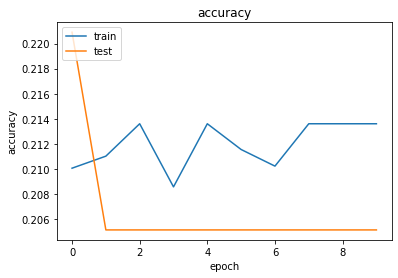

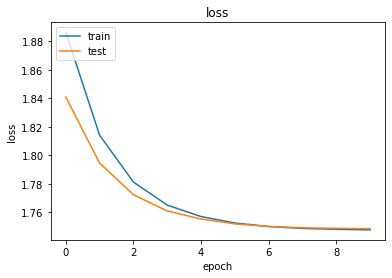

In [42]:
for x in ["accuracy", "loss"]:
    plt.plot(hist.history[x])
    plt.plot(hist.history[f"val_{x}"])
    plt.title(x)
    plt.ylabel(x)
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()


In [43]:
y_pred_prob = model.predict(X_test)
y_pred = [np.argmax(x) for x in y_pred_prob]

__ = {}
for k in y_pred:
    if __.get(k) == None:
        __[k] = 0
    __[k] += 1

print(__) ## sadly model recognises all text as business

{0: 9439}


In [44]:
## change back to words instead of 0-6
y_pred = [y_map[x] for x in y_pred]
y_test = [y_map[x] for x in y_test]


In [45]:
accuracy = metrics.accuracy_score(y_test, y_pred)
roc = metrics.roc_auc_score(y_test, y_pred_prob, multi_class="ovr")
class_report = metrics.classification_report(y_test, y_pred)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Visualisations

In [46]:
print(class_report)


              precision    recall  f1-score   support

    business       0.21      1.00      0.35      2000
    consumer       0.00      0.00      0.00       291
     finance       0.00      0.00      0.00      2000
     general       0.00      0.00      0.00      2000
  healthcare       0.00      0.00      0.00       268
     science       0.00      0.00      0.00       912
        tech       0.00      0.00      0.00      1968

    accuracy                           0.21      9439
   macro avg       0.03      0.14      0.05      9439
weighted avg       0.04      0.21      0.07      9439



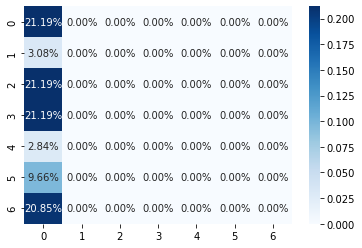

In [47]:
sns.heatmap(
    confusion_matrix / np.sum(confusion_matrix), fmt=".2%", annot=True, cmap="Blues"
)
plt.show()


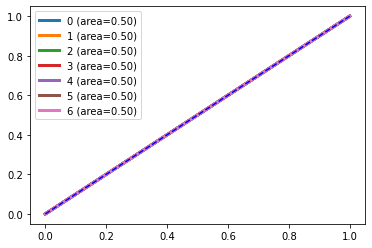

In [48]:
## https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
classes = [x for x in range(7)]
y_test_array = pd.get_dummies(y_test, drop_first=False).values
fig, ax = plt.subplots()
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:, i], y_pred_prob[:, i])
    ax.plot(
        fpr,
        tpr,
        lw=3,
        label="{0} (area={1:0.2f})".format(classes[i], metrics.auc(fpr, tpr)),
    )
ax.plot([0, 1], [0, 1], color="blue", linestyle="--")
ax.legend()


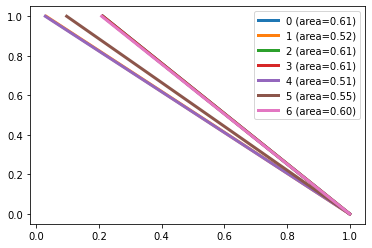

In [49]:
y_test_array = pd.get_dummies(y_test, drop_first=False).values
fig, ax = plt.subplots()
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
        y_test_array[:, i], y_pred_prob[:, i]
    )
    ax.plot(
        precision,
        recall,
        lw=3,
        label="{0} (area={1:0.2f})".format(classes[i], metrics.auc(recall, precision)),
    )
ax.legend()
